# Collating Results

<br><br>
___
### Cleaning Data

In [2]:
# !git clone https://github.com/Sakib56/MInf-2.0-DeepFake-Detection.git
# %cd "/content/MInf-2.0-DeepFake-Detection"

In [3]:
from scipy.stats import ttest_ind, ttest_rel
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from scipy.stats import t
import seaborn as sns
import pandas as pd
import numpy as np
import os

sns.set()
plt.rc('font', family = 'serif')

# os.listdir(".")

In [4]:
def get_metric_from_file(fpath, metric="auc"):
    with open(fpath, "r") as f:
        f.readline() # (experiment_name, model_name, test_dataset, fpath)
        auc = f.readline()
        f1 = f.readline()
        prec = f.readline()
        recall = f.readline()
        metrics = {
            "auc": auc,
            "f1": f1,
            "prec": prec,
            "recall": recall,
        }
    chosen_metric = metrics[metric.lower()]
    return float(chosen_metric.strip().split("=")[-1])

get_all_metrics = lambda t: [
    get_metric_from_file(t, "auc"),
    get_metric_from_file(t, "f1"),
    get_metric_from_file(t, "prec"),
    get_metric_from_file(t, "recall"),
]

COL_HDRS = ["Model", "AUC", "F1", "Precision", "Recall"]

def create_pd(model_results_txts, model_results_dir):
    model_results_txts = [f"{model_results_dir}{f}" for f in os.listdir(model_results_dir) if ".txt" in f]
    tuple_list = [tuple( [v.split("/")[-1].replace(".txt", "")] + 
                                    get_all_metrics(v) ) 
                                        for v in model_results_txts]
    return pd.DataFrame(tuple_list, columns=COL_HDRS)

def categorise_names(t):
    tstst = t[-1].lower()
    if "run" in tstst:
        # cdfv2runningavg -> raeonCDFv2avg
        t[-1] = "rae"+t[-1].replace("running", "")
    if "on" in tstst:
        # raeondfavg -> raeDFavg
        t[-1] = t[-1].replace("on", "")
    if "cdfv2" in tstst:
        # cdfv2avg -> AVG
        t[-1] = t[-1].lower().replace("cdfv2", "").upper()
        # cdfv2runningavg -> raeAVG
        t[-1] = t[-1].replace("RAE", "rae")
    if t[-1] == "AVG" or t[-1] == "RND":
        # AVG -> CDFv2avg
        t[-1] = "CDFv2"+t[-1].lower()
        # print(tstst, t[-1])
    if t[-2] == "AVG" or t[-2] == "RND":
        t[-2] = "CDFv2"+t[-2].lower()

    return t

def welch_ttest(x1, x2, alternative):
    n1 = x1.size
    n2 = x2.size
    m1 = np.mean(x1)
    m2 = np.mean(x2)
    v1 = np.var(x1, ddof=1)
    v2 = np.var(x2, ddof=1)
    tstat = (m1 - m2) / np.sqrt(v1 / n1 + v2 / n2)
    df = (v1 / n1 + v2 / n2)**2 / (v1**2 / (n1**2 * (n1 - 1)) + v2**2 / (n2**2 * (n2 - 1)))
    if alternative == "equal":
        p = 2 * t.cdf(-abs(tstat), df)
    if alternative == "lesser":
        p = t.cdf(tstat, df)
    if alternative == "greater":
        p = 1-t.cdf(tstat, df)
    return tstat, df, p

def clean_latex(latex_str):
    latex_str = latex_str.replace("Model\\_Name", "Model")
    latex_str = latex_str.replace("is\\_RAE", "Evaluation Method ( 0=SE, 1=RAE )")
    latex_str = latex_str.replace("is\\_AVG\\_Trainset", "Trainset Pre-Processing ( 0=RF, 1=AF )")
    latex_str = latex_str.replace("is\\_AVG\\_Testset", "Testset Pre-Processing ( 0=RF, 1=AF )")

    latex_str = latex_str.replace("Model_Name", "Model")
    latex_str = latex_str.replace("is_RAE", "Evaluation Method ( 0=SE, 1=RAE )")
    latex_str = latex_str.replace("is_AVG_Trainset", "Trainset Pre-Processing ( 0=RF, 1=AF )")
    latex_str = latex_str.replace("is_AVG_Testset", "Testset Pre-Processing ( 0=RF, 1=AF )")
    return latex_str

In [5]:
baseline_results_dir = "./_BASELINE_TESTS/Results/"
oc_fakedect1_results_dir = "./_TRAINING/OC-FakeDect-Implementation/Results/"
vit_results_dir = "./_TRAINING/ViT/Results/"

In [6]:
baseline_results_txts = [f"{baseline_results_dir}{f}" for f in os.listdir(baseline_results_dir) if ".txt" in f]
oc_fakedect1_results_txts = [f"{oc_fakedect1_results_dir}{f}" for f in os.listdir(oc_fakedect1_results_dir) if ".txt" in f]
vit_results_txts = [f"{oc_fakedect1_results_dir}{f}" for f in os.listdir(vit_results_dir) if ".txt" in f]

In [7]:
vit_df = create_pd(vit_results_txts, vit_results_dir)
baseline_df = create_pd(baseline_results_txts, baseline_results_dir)
oc_fakedect1_df = create_pd(oc_fakedect1_results_txts, oc_fakedect1_results_dir)
df = pd.concat([vit_df, baseline_df, oc_fakedect1_df])
df = df.sort_values(by=["AUC", "F1", "Precision", "Recall"], ascending=[False]*4)

In [8]:
# Find best
model_names_split = [(m, m.split("_")) for m in df["Model"]]
remove_list = [m for m, ms in model_names_split if len(ms)>3]
print("Remove Rows", str(remove_list).replace(",", ",\n"), sep="\n")
df = df[~df["Model"].isin(remove_list)]

Remove Rows
['ViT_Celeb_rnd_30_0224_2353',
 'ViT_Celeb_rnd_30_0223_1926',
 'ViT_Celeb_rnd_30_train_0223_1755',
 'ViT_DariusAf_Deepfake_Database_0223_1831']


In [9]:
set([m.split("_")[0] for m in df["Model"]]) # Models look good

{'Meso4', 'MesoInception', 'OC-FakeDect1', 'ViT'}

In [10]:
set([m.split("_")[1] for m in df["Model"]]) # Trainsets look good, NOTE: DF & F2F are only for Mesos

{'AVG', 'DF', 'DFDB', 'F2F', 'RND'}

In [11]:
set([m.split("_")[2] for m in df["Model"]])

{'CDFv2avg',
 'CDFv2rnd',
 'CDFv2runningavg',
 'CDFv2runningrnd',
 'DFDB',
 'DFavg',
 'DFrnd',
 'F2Favg',
 'F2Frnd',
 'FSHFTavg',
 'FSHFTrnd',
 'FSavg',
 'FSrnd',
 'NTavg',
 'NTrnd',
 'onAVG',
 'onDFDB',
 'onRND',
 'raeonAVG',
 'raeonDFavg',
 'raeonDFrnd',
 'raeonF2Favg',
 'raeonF2Frnd',
 'raeonFSHFTavg',
 'raeonFSHFTrnd',
 'raeonFSavg',
 'raeonFSrnd',
 'raeonNTavg',
 'raeonNTrnd',
 'raeonRND'}

In [12]:
model_names_split = [[m.split("_"), m] for m in df["Model"]] # re-do bc df changed
cat_names_list = [categorise_names(ms) + [m] for ms, m in model_names_split] # for inner join on the df
# cat_names_list

In [13]:
df2 = pd.DataFrame(cat_names_list, columns=["Model_Name", "Trainset", "Testset", "Model"])
df = df2.merge(df, left_on="Model", right_on="Model")
df = df[[c for c in df.columns if c != "Model"]].sort_values(by=["AUC", "F1", "Precision", "Recall"], ascending=[False]*4)
df['Testset'] = df['Testset'].map(lambda x: x.replace("AVG", "CDFv2avg"))
df['Testset'] = df['Testset'].map(lambda x: x.replace("RND", "CDFv2rnd"))

pd.set_option('display.max_rows', df.shape[0]+1)
df = df.round(3)
df = df.sort_values(by=["AUC", "F1", "Precision", "Recall"], ascending=[False]*4)

In [14]:
df["is_RAE"] = 0
df.loc[df["Testset"].str.contains("rae"), "is_RAE"] = 1
df["is_AVG_Trainset"] = 0
df.loc[df["Trainset"].str.contains("avg"), "is_AVG_Trainset"] = 1
df["is_AVG_Testset"] = 0
df.loc[df["Testset"].str.contains("avg"), "is_AVG_Testset"] = 1
df['Testset'] = df['Testset'].replace(['CDFv2avg', "CDFv2rnd"], 'CDFv2')
df['Testset'] = df['Testset'].map(lambda x: x.replace("rae", ""))
df['Testset'] = df['Testset'].map(lambda x: x.replace("avg", ""))
df['Testset'] = df['Testset'].map(lambda x: x.replace("rnd", ""))
df['Testset'] = df['Testset'].replace(['AVG'], 'CDFv2')
df['Testset'] = df['Testset'].replace(['RND'], 'CDFv2')
df['Trainset'] = df['Trainset'].map(lambda x: x.replace("avg", ""))
df['Trainset'] = df['Trainset'].map(lambda x: x.replace("rnd", ""))

df = df.drop_duplicates(subset=['Model_Name', "Trainset", "Testset", "is_RAE", "is_AVG_Trainset", "is_AVG_Testset"])
df.index = range(1, len(df)+1) # index from 1 for latex

<br><br>
___
### Data Showcase

#### Top AUC 20 Models

In [15]:
# DONT USE THIS IN PAPER (IT'S NOT USEFUL)
df[:20] # all models sorted by AUC (top 20)

,Model_Name,Trainset,Testset,AUC,F1,Precision,Recall,is_RAE,is_AVG_Trainset,is_AVG_Testset
1,MesoInception,DF,DFDB,0.975,0.925,0.953,0.900,0,0,0
2,Meso4,DF,DFDB,0.962,0.904,0.930,0.880,0,0,0
3,MesoInception,F2F,F2F,0.905,0.318,0.252,0.430,1,0,0
4,Meso4,F2F,F2F,0.905,0.128,0.118,0.139,1,0,0
5,ViT,CDFv2,CDFv2,0.864,0.963,0.930,0.999,1,0,0
6,ViT,CDFv2,CDFv2,0.860,0.953,0.944,0.964,1,1,0
7,ViT,CDFv2,CDFv2,0.857,0.963,0.932,0.996,1,1,1
8,Meso4,DF,DF,0.856,0.175,0.159,0.194,1,0,0
9,MesoInception,DF,DF,0.844,0.174,0.159,0.190,1,0,0
10,ViT,CDFv2,CDFv2,0.831,0.960,0.930,0.993,0,0,0


#### Top AUC Models For Each Test Set

In [16]:
best_models = df.drop_duplicates(subset=["Testset"])
best_models

print(clean_latex(best_models.to_latex(
    label="tab:best_models", 
    column_format="c"*10, 
    index=True,
    )))

\begin{table}
\centering
\label{tab:best_models}
\begin{tabular}{cccccccccc}
\toprule
{} &     Model & Trainset & Testset &    AUC &     F1 &  Precision &  Recall &  Evaluation Method ( 0=SE, 1=RAE ) &  Trainset Pre-Processing ( 0=RF, 1=AF ) &  Testset Pre-Processing ( 0=RF, 1=AF ) \\
\midrule
1  &  MesoInception &       DF &    DFDB &  0.975 &  0.925 &      0.953 &   0.900 &       0 &                0 &               0 \\
3  &  MesoInception &      F2F &     F2F &  0.905 &  0.318 &      0.252 &   0.430 &       1 &                0 &               0 \\
5  &            ViT &    CDFv2 &   CDFv2 &  0.864 &  0.963 &      0.930 &   0.999 &       1 &                0 &               0 \\
8  &          Meso4 &       DF &      DF &  0.856 &  0.175 &      0.159 &   0.194 &       1 &                0 &               0 \\
28 &          Meso4 &       DF &   FSHFT &  0.704 &  0.380 &      0.316 &   0.476 &       1 &                0 &               0 \\
50 &            ViT &    CDFv2 &      NT &  0

C:\Users\rapto\AppData\Local\Temp\ipykernel_14420\3439737910.py:4: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(clean_latex(best_models.to_latex(


#### Top AUC Baselines Models For Each Test Set

In [17]:
best_baselines = df[df["Model_Name"].isin(["Meso4", "MesoInception"])]
best_baselines = best_baselines.drop_duplicates(subset=["Testset"])
best_baselines

# print(clean_latex(best_baselines.to_latex(
#     label="tab:best_baselines", 
#     column_format="c"*10, 
#     index=True,
#     )))

,Model_Name,Trainset,Testset,AUC,F1,Precision,Recall,is_RAE,is_AVG_Trainset,is_AVG_Testset
1,MesoInception,DF,DFDB,0.975,0.925,0.953,0.900,0,0,0
3,MesoInception,F2F,F2F,0.905,0.318,0.252,0.430,1,0,0
8,Meso4,DF,DF,0.856,0.175,0.159,0.194,1,0,0
28,Meso4,DF,FSHFT,0.704,0.380,0.316,0.476,1,0,0
38,MesoInception,F2F,CDFv2,0.673,0.908,0.915,0.902,1,0,1
81,MesoInception,DF,NT,0.628,0.445,0.363,0.573,1,0,0
104,MesoInception,DF,FS,0.602,0.211,0.287,0.166,1,0,1


#### Top AUC ViT Models For Each Test Set

In [18]:
best_vits = df[df["Model_Name"].isin(["ViT"])]
best_vits = best_vits.drop_duplicates(subset=["Testset"])
best_vits

# print(clean_latex(best_vits.to_latex(
#     label="tab:best_vits", 
#     column_format="c"*10, 
#     index=True,
#     )))

,Model_Name,Trainset,Testset,AUC,F1,Precision,Recall,is_RAE,is_AVG_Trainset,is_AVG_Testset
5,ViT,CDFv2,CDFv2,0.864,0.963,0.930,0.999,1,0,0
18,ViT,CDFv2,DF,0.770,0.661,0.511,0.933,1,1,0
21,ViT,CDFv2,DFDB,0.757,0.958,0.922,0.997,0,0,0
35,ViT,CDFv2,FSHFT,0.675,0.621,0.463,0.940,1,1,1
50,ViT,CDFv2,NT,0.650,0.594,0.597,0.592,0,1,0
61,ViT,CDFv2,F2F,0.646,0.601,0.440,0.946,1,0,0
74,ViT,CDFv2,FS,0.633,0.597,0.603,0.592,0,1,0


#### Top AUC OC-FakeDect1 Models For Each Test Set

In [19]:
best_ocfds = df[df["Model_Name"].isin(["OC-FakeDect1"])]
best_ocfds = best_ocfds.drop_duplicates(subset=["Testset"])
best_ocfds

# print(clean_latex(best_ocfds.to_latex(
#     label="tab:best_ocfds", 
#     column_format="c"*10, 
#     index=True,
#     )))

,Model_Name,Trainset,Testset,AUC,F1,Precision,Recall,is_RAE,is_AVG_Trainset,is_AVG_Testset
48,OC-FakeDect1,DFDB,DF,0.651,0.380,0.298,0.525,0,0,0
51,OC-FakeDect1,DFDB,FS,0.650,0.381,0.299,0.527,0,0,1
52,OC-FakeDect1,DFDB,FSHFT,0.650,0.381,0.299,0.527,0,0,0
55,OC-FakeDect1,DFDB,NT,0.649,0.381,0.299,0.525,0,0,0
58,OC-FakeDect1,DFDB,F2F,0.648,0.382,0.300,0.528,0,0,1
66,OC-FakeDect1,DFDB,CDFv2,0.645,0.388,0.303,0.541,0,0,1
71,OC-FakeDect1,DFDB,DFDB,0.638,0.403,0.311,0.572,0,0,0


<br><br>
___
## Analysis

### General

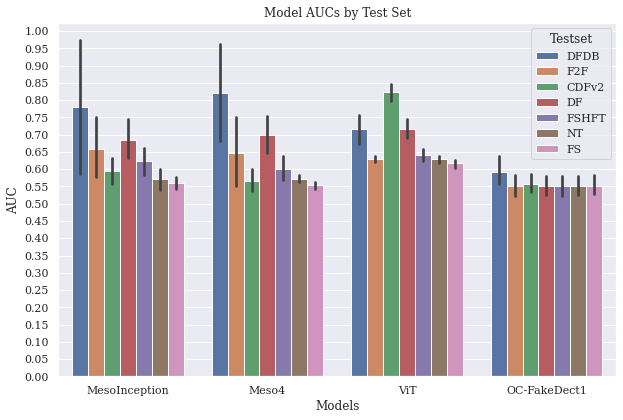

In [20]:
plt.figure(figsize=(10,6.5))
ax = sns.barplot(
    x="Model_Name", 
    y="AUC",
    hue="Testset", 
    data=df, 
)
ax.set_title(f"Model AUCs by Test Set")
ax.set_yticks(np.arange(0, 1.05, 0.05))
ax.set_xlabel("Models")
plt.savefig(
    "./_PLOTS/Model AUCs by Test Set.pdf", 
    bbox_inches="tight"
    )
plt.show()

### Pre-Processing vs Evaluation Method

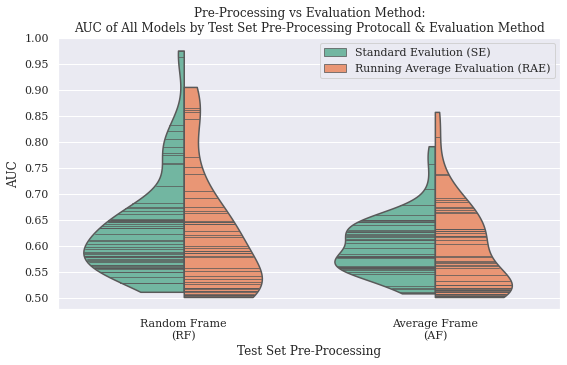

In [21]:
plt.figure(figsize=(9,5))
ax = sns.violinplot(
    x="is_AVG_Testset", 
    y='AUC', 
    hue="is_RAE", 
    data=df, 
    inner="stick",
    split=True, 
    cut=0,  
    palette="Set2",
    aspect=1,
    height=100,
    )
ax.set_title(f"Pre-Processing vs Evaluation Method:\nAUC of All Models by Test Set Pre-Processing Protocall & Evaluation Method")
ax.set_xticklabels([
    "Random Frame\n(RF)", 
    "Average Frame\n(AF)",
    ])
ax.legend(
    handles=ax.legend_.legendHandles, 
    labels=['Standard Evalution (SE)', 
    'Running Average Evaluation (RAE)',
    ])
ax.set_xlabel("Test Set Pre-Processing")
ax.set_ylabel("AUC")
ax.set_yticks(np.arange(0.5, 1.05, 0.05));
# ax.set_size_inches(18.5, 10.5)
plt.savefig(
    "./_PLOTS/Pre-Processing vs Evaluation Method.pdf", 
    bbox_inches="tight"
    )
plt.show()

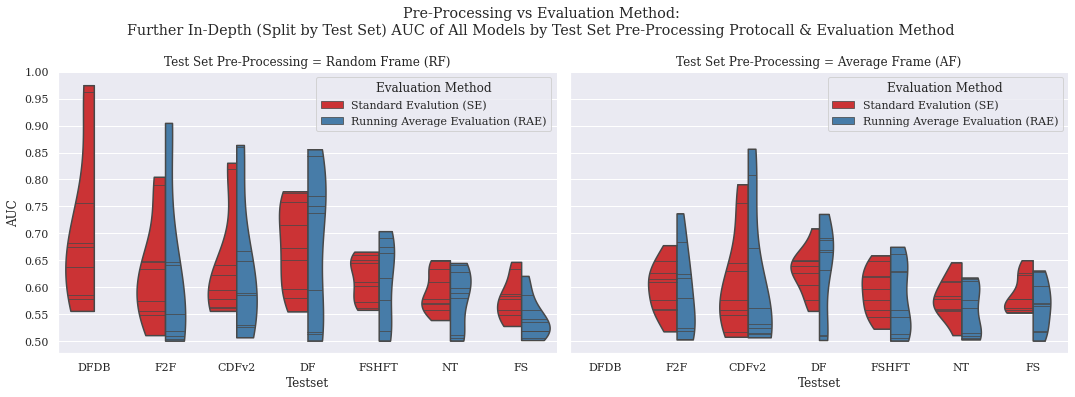

In [22]:
ax = sns.catplot(
    x="Testset", 
    y="AUC",
    hue="is_RAE", 
    col="is_AVG_Testset",
    data=df, 
    kind="violin", 
    split=True,
    height=5, 
    aspect=3/2, 
    palette="Set1", 
    cut=0, 
    inner="stick", 
    legend_out=False,
);
ax.fig.suptitle(
    f"Pre-Processing vs Evaluation Method:\nFurther In-Depth (Split by Test Set) AUC of All Models by Test Set Pre-Processing Protocall & Evaluation Method",
    y=1.1,
    fontdict={"weight": "bold"},
)
ax.axes[0][0].set_title(f"Test Set Pre-Processing = Random Frame (RF)")
ax.axes[0][1].set_title(f"Test Set Pre-Processing = Average Frame (AF)")
ax, bx = ax.axes[0][0], ax.axes[0][1]
bx.legend()
bx.legend(
    handles=bx.legend_.legendHandles, 
    labels=['Standard Evalution (SE)', 'Running Average Evaluation (RAE)'], 
    loc="best",
    title="Evaluation Method")
ax.legend(
    handles=bx.legend_.legendHandles, 
    labels=['Standard Evalution (SE)', 'Running Average Evaluation (RAE)'], 
    loc="best",
    title="Evaluation Method")
ax.set_yticks(np.arange(0.5, 1.05, 0.05))
plt.savefig(
    "./_PLOTS/Pre-Processing vs Evaluation Method by Test Set.pdf", 
    bbox_inches="tight"
    )
plt.show()

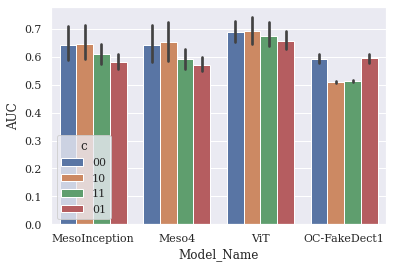

In [23]:
dfx = df.copy()
dfx["c"] = df['is_RAE'].astype(str) + df['is_AVG_Testset'].astype(str) #+ df['is_AVG_Testset']
dfx

ax = sns.barplot(
    x="Model_Name", 
    y="AUC",
    hue="c", 
    data=dfx, 
)

<br><br>
___
## Misc

In [24]:
best_models

,Model_Name,Trainset,Testset,AUC,F1,Precision,Recall,is_RAE,is_AVG_Trainset,is_AVG_Testset
1,MesoInception,DF,DFDB,0.975,0.925,0.953,0.900,0,0,0
3,MesoInception,F2F,F2F,0.905,0.318,0.252,0.430,1,0,0
5,ViT,CDFv2,CDFv2,0.864,0.963,0.930,0.999,1,0,0
8,Meso4,DF,DF,0.856,0.175,0.159,0.194,1,0,0
28,Meso4,DF,FSHFT,0.704,0.380,0.316,0.476,1,0,0
50,ViT,CDFv2,NT,0.650,0.594,0.597,0.592,0,1,0
51,OC-FakeDect1,DFDB,FS,0.650,0.381,0.299,0.527,0,0,1


<AxesSubplot:xlabel='is_RAE', ylabel='AUC'>

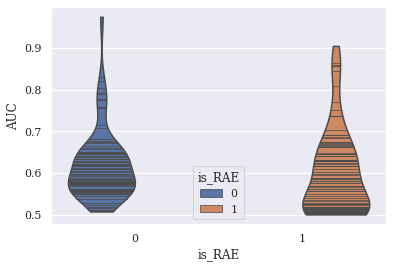

In [25]:
sns.violinplot(x='is_RAE', y='AUC', hue="is_RAE", data=df, inner="stick", cut=0)

In [26]:
# vit_df = best_df[best_df["Model_Name"].isin(["ViT"])].sort_values(by=["AUC", "F1", "Precision", "Recall"], ascending=[False]*4)
# vit_df

# rae vs non-rae
vit_rae = best_vits[best_vits["Testset"].str.contains("rae")]
vit_nonrae = best_vits[~best_vits["Testset"].str.contains("rae")]
vit_nonrae = vit_nonrae[~vit_nonrae["Testset"].str.contains("DFDB")] # no eq lens

# ttest_rel assumes relationship, and not eqal var
vit_raeVnonrae_pvalue = ttest_rel(vit_rae['AUC'], vit_nonrae['AUC'], alternative="greater")[1] 
# p<0.05 means not alternative (vit_rae['AUC'] > vit_nonrae['AUC'])

data1 = vit_rae[["AUC"]].assign(RAE=1)
data2 = vit_nonrae[["AUC"]].assign(RAE=0)

cdf = pd.concat([data1, data2])
mdf = pd.melt(cdf, id_vars=['RAE'], var_name=['AUC'])

# LOOK AT https://seaborn.pydata.org/generated/seaborn.violinplot.html
ax = sns.violinplot(x='RAE', y='value', hue="RAE", data=mdf, inner="stick", cut=0)#, split=True)
ax.set_title(f"ViT AUCs for Standard Evalution vs Running Average Evaluation\n2-Tailed T-Test w/ Alternative Hypethesis (RAE>SE)\np-value = {vit_raeVnonrae_pvalue:.4f} $\\rightarrow$ Accept Alternative Hypethesis ")
ax.set_xticklabels(["Standard Evalution (SE)", "Running Average Evaluation (RAE)"])
ax.set_xlabel("Evaluation Method")
ax.set_ylabel("AUC")
ax.get_legend().remove()
plt.show()



ValueError: unequal length arrays

In [ ]:
ax = sns.violinplot(x='Model_Name', y='AUC', hue="is_RAE", data=df, inner="stick", cut=0, split=True, scale="width")


In [ ]:
vit_df = best_df[best_df["Model_Name"].isin(["ViT"])].sort_values(by=["AUC", "F1", "Precision", "Recall"], ascending=[False]*4)
# vit_df

# rae vs non-rae
vit_rae = vit_df[vit_df["Testset"].str.contains("rae")]
vit_nonrae = vit_df[~vit_df["Testset"].str.contains("rae")]
vit_nonrae = vit_nonrae[~vit_nonrae["Testset"].str.contains("DFDB")] # no eq lens

# ttest_rel assumes relationship, and not eqal var
vit_raeVnonrae_pvalue = ttest_rel(vit_rae['AUC'], vit_nonrae['AUC'], alternative="greater")[1] 
# p<0.05 means not alternative (vit_rae['AUC'] > vit_nonrae['AUC'])

data1 = vit_rae[["AUC"]].assign(RAE=1)
data2 = vit_nonrae[["AUC"]].assign(RAE=0)

cdf = pd.concat([data1, data2])
mdf = pd.melt(cdf, id_vars=['RAE'], var_name=['AUC'])

# LOOK AT https://seaborn.pydata.org/generated/seaborn.violinplot.html
ax = sns.violinplot(x='RAE', y='value', hue="RAE", data=mdf, inner="stick", cut=0)#, split=True)
ax.set_title(f"ViT AUCs for Standard Evalution vs Running Average Evaluation\n2-Tailed T-Test w/ Alternative Hypethesis (RAE>SE)\np-value = {vit_raeVnonrae_pvalue:.4f} $\\rightarrow$ Accept Alternative Hypethesis ")
ax.set_xticklabels(["Standard Evalution (SE)", "Running Average Evaluation (RAE)"])
ax.set_xlabel("Evaluation Method")
ax.set_ylabel("AUC")
ax.get_legend().remove()
plt.show()



In [ ]:



set(df["Testset"]), set(df["Trainset"])

In [ ]:
# rae vs non-rae by test_dataset
sns.violinplot(x="Testset", y='AUC', hue="is_RAE", data=df, split=True, cut=0, scale="width")#, palette="Set1")

In [ ]:
# avg vs rnd
sns.violinplot(x="Testset", y='AUC', hue="is_AVG_Testset", data=df, inner="stick", split=True, cut=0, palette="Set1")

In [ ]:
# best models
best_df = df.sort_values(by=["AUC", "F1", "Precision", "Recall"], ascending=[False]*4)
best_df.loc[best_df[["Testset"]].drop_duplicates().index] # top models by testset sorted by AUC

In [ ]:
# sns.violinplot(x="Model_Name", y='AUC', hue="is_RAE", data=df, inner="stick", split=True, width=1)
# sns.violinplot(x="Model_Name", y='AUC', hue="is_AVG_Testset", data=df, inner="stick", split=True)

ax1 = sns.violinplot(x="Testset", y='AUC', hue="is_RAE", data=df, split=True, cut=0)
ax2 = sns.violinplot(x="Testset", y='AUC', hue="is_AVG_Testset", data=df, split=True, cut=0, palette="Set3")#, dodge=True)
plt.setp(ax2.collections, alpha=.65)
plt.show()

In [ ]:
# testset is avg vs rae eval
sns.violinplot(x="is_AVG_Testset", y='AUC', hue="is_RAE", data=df, inner="stick", split=True, cut=0,  palette="Set2")

sns.catplot(x="Testset", y="AUC",
                hue="is_RAE", col="is_AVG_Testset",
                data=df, kind="violin", split=True,
                height=10, aspect=1, palette="Set1", cut=0, inner="stick");